In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as TTS
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.interpolate import griddata

import warnings
warnings.filterwarnings("ignore")

In [2]:
X, y = make_regression(n_samples=2000, 
                       n_features=10,
                       n_informative=7,
                       n_targets=1, 
                       bias=0, 
                       noise=0.5, 
                       random_state=42)

In [3]:
X_train, X_test, y_train, y_test = TTS(X, y, 
                                       test_size=0.2, 
                                       random_state=42)

Train rmse: 5.8968490518108805
Test rmse: 6.7400015536463345


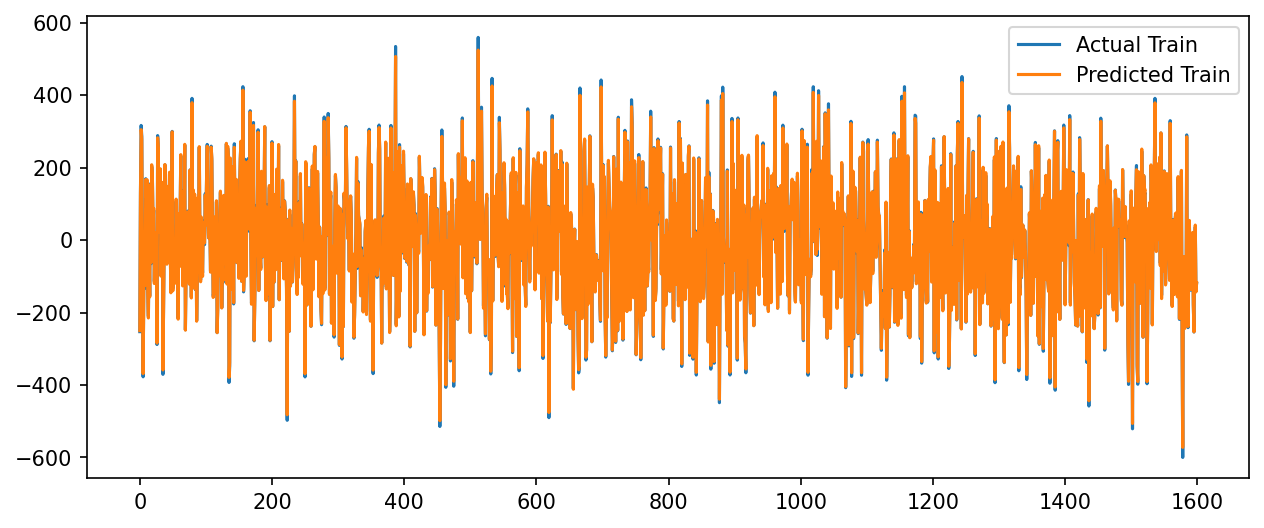

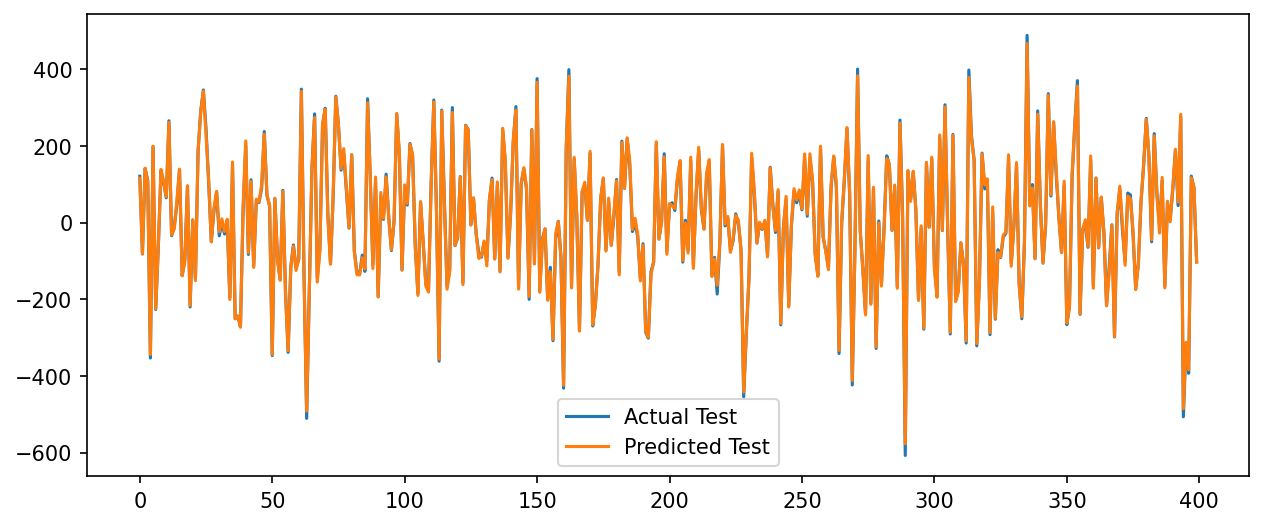

In [4]:
reg = MLPRegressor(hidden_layer_sizes=(20,20,), max_iter=300)

reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
rmse_train = mean_squared_error(y_train_pred, y_train)**0.5

y_test_pred = reg.predict(X_test)
rmse_test = mean_squared_error(y_test_pred, y_test)**0.5

print(f'Train rmse: {rmse_train}')
print(f'Test rmse: {rmse_test}')

plt.figure(figsize=(10,4),dpi=150)
plt.plot(y_train, label='Actual Train')
plt.plot(y_train_pred, label='Predicted Train')
plt.legend()

plt.figure(figsize=(10,4),dpi=150)
plt.plot(y_test, label='Actual Test')
plt.plot(y_test_pred, label='Predicted Test')
plt.legend()

In [5]:
# Configuration
n = 10000  # number of random initializations
hidden_layer_sizes=(20,20,)

# Store results
results = []

for i in range(n):
    # Create untrained model
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=1, warm_start=False)

    # Fit once to initialize weights
    model.fit(X[:1], y[:1])  # Fit on a single sample to initialize weights (not for training)
    
    # Randomize weights manually
    for i, coefs in enumerate(model.coefs_):
        model.coefs_[i] = np.random.randn(*coefs.shape)*0.5 # Return a sample (or samples) from the “standard normal” distribution.
    for i, intercepts in enumerate(model.intercepts_):
        model.intercepts_[i] = np.random.randn(*intercepts.shape)*0.5

    # Do forward pass manually to get predictions
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred)**0.5

    # Store weights and mse
    weights = {
        "coefs": [w.copy() for w in model.coefs_],
        "intercepts": [b.copy() for b in model.intercepts_],
        "rmse": rmse
    }
    results.append(weights)

results contains the information of n neural networks. results[0] shows the information of the first neural net. results[0]['coefs'] shows the coefficients of the first neural net. Since we have three layers, it contains three lists. To look at the weights between the input and first hidden layer, we can use results[0]['coefs'][0] which contains 10 lists (number of input features). Each list has 20 weights in it (number of neurons in the first hidden layer) which is accessible using results[0]['coefs'][0][0].

In [6]:
rows = []
for result in results:
    row = {}
    # Flatten each weight matrix; include an index in the key to keep track of different matrices and their positions.
    for layer_idx, weight_matrix in enumerate(result["coefs"]):
        flattened = weight_matrix.flatten()
        for pos, value in enumerate(flattened):
            row[f'W_coef_{layer_idx}_{pos}'] = value
    # Flatten each intercept vector similarly.
    for layer_idx, intercept_vector in enumerate(result["intercepts"]):
        flattened = intercept_vector.flatten()
        for pos, value in enumerate(flattened):
            row[f'W_intercept_{layer_idx}_{pos}'] = value
    # Store mse
    row['rmse'] = result['rmse']
    rows.append(row)

df = pd.DataFrame(rows)

In [7]:
# Step 1: Separate features (weights/intercepts) from the target (MSE)
features = df.drop(columns=['rmse'])
rmse = df['rmse']

# Step 2: Apply PCA to reduce the feature dimensions to 2
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features)

# Create a DataFrame that includes the two PCA components and the mse.
df_pca = pd.DataFrame({
    'PC1': pca_components[:, 0],
    'PC2': pca_components[:, 1],
    'rmse': rmse
})

In [8]:
# Step 3: Plot an interactive 3D scatter plot using Plotly Express
fig = px.scatter_3d(
    df_pca,
    x='PC1',
    y='PC2',
    z='rmse',
    title='PCA of Weights and Intercepts vs. RMSE',
    labels={'PC1': 'PC 1',
            'PC2': 'PC 2',
            'mse': 'Root Mean Squared Error'},
    hover_data=['rmse']
)
# Make the plot window larger
fig.update_layout(
    width=750,  # width in pixels
    height=600   # height in pixels
)

fig.show()

In [9]:
# Assume df_pca has 'PC1', 'PC2', and 'rmse'
xx = df_pca['PC1']
yy = df_pca['PC2']
zz = df_pca['rmse']

# This creates a regular 2D grid of 100×100 points (100j means 100 steps using complex notation for linspace)
# This is like laying graph paper over the PCA plane — you’ll estimate the error (RMSE) at every grid point (100*100 points)
grid_x, grid_y = np.mgrid[
    xx.min():xx.max():100j,
    yy.min():yy.max():100j
]

# griddata() interpolates z values (RMSE) over the new regular grid using the known x, y, and z data points.
# The interpolation method:
# 'cubic': smoothest, fits a curved surface.
# 'linear': less smooth.
# 'nearest': blocky, just copies nearest value.
grid_z = griddata(
    points=(xx, yy),
    values=zz,
    xi=(grid_x, grid_y),
    method='cubic'  # linear, nearest, cubic
)

In [10]:
fig = go.Figure(data=[
    go.Surface(
        z=grid_z,
        x=grid_x[:, 0], # Takes the x-axis values (same for each row of the grid)
        y=grid_y[0, :], # Takes the y-axis values (same for each column of the grid).
        colorscale='Turbo',
        contours=dict(
        z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True)
        ),
        colorbar=dict(title='RMSE')
    )
])

fig.update_layout(
    title='Smoothed Error Surface in PCA-Reduced Weight Space',
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='RMSE'
    ),
    width=1000,
    height=600
)

fig.show()

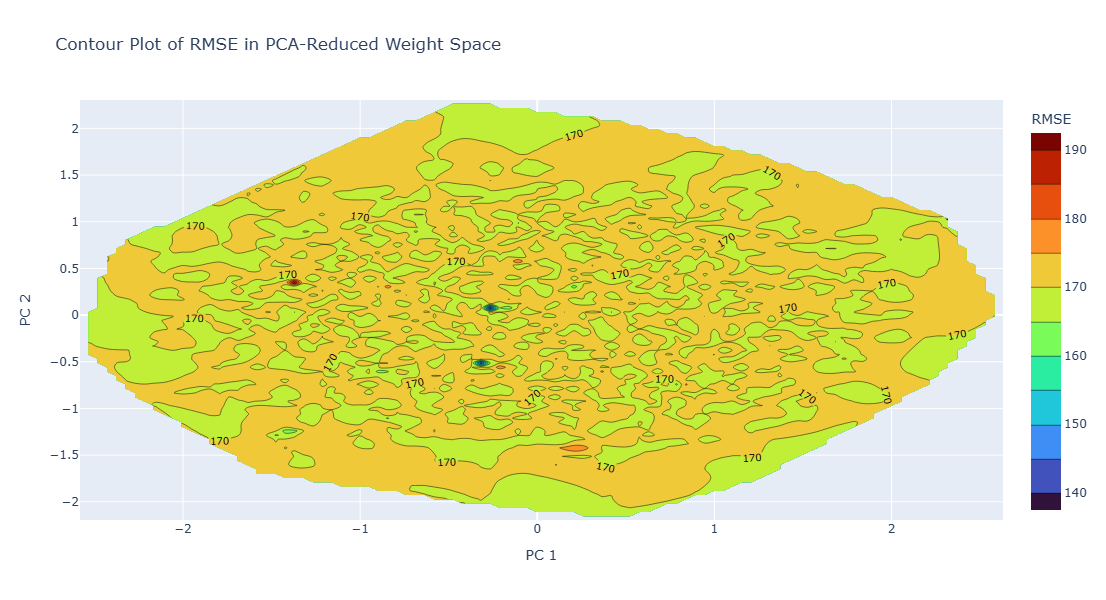

In [11]:
# Create a contour plot
fig = go.Figure(data=go.Contour(
    z=grid_z,  # Interpolated RMSE values
    x=grid_x[:, 0],  # PC1 values (x-axis)
    y=grid_y[0, :],  # PC2 values (y-axis)
    colorscale='Turbo',  # Choose any color scale you prefer
    colorbar=dict(title='RMSE'),  # Colorbar to represent RMSE values
    contours=dict(
        showlabels=True,  # Show contour labels if you like
        labelfont=dict(size=10)  # Font size for contour labels
    )
))

# Customize layout
fig.update_layout(
    title='Contour Plot of RMSE in PCA-Reduced Weight Space',
    xaxis_title='PC 1',
    yaxis_title='PC 2',
    width=800,
    height=600
)

# Show the plot
fig.show()